In [1]:
import pypowsybl.network as pn
network = pn.load('/home/dupuyflo/Data/LFE_2025/fr_1850.xiidm')

In [2]:
import pypowsybl.loadflow as lf
lf.run_ac(network)

[ComponentResult(connected_component_num=0, synchronous_component_num=0, status=CONVERGED, status_text=Converged, iteration_count=7, reference_bus_id='CHAFFP7_0', slack_bus_results=[SlackBusResult(id='CHAFFP7_0', active_power_mismatch=-0.5088339270259201)], distributed_active_power=28.570841706134765)]

In [3]:
from pypowsybl_jupyter import network_explorer
network_explorer(network, depth=2, vl_id='STRASP3', nad_parameters=pn.NadParameters(injections_added=True))

In [4]:
branches = network.get_branches(attributes=['bus1_id', 'bus2_id'])
branches

,bus1_id,bus2_id
id,,
.CTLHL31.CTLO,.CTLHP3_0,
.CTLHL32.CTLO,.CTLHP3_1,.CTLOP3_3
.CTLOL31FINS,.CTLOP3_0,FINS P3_0
.CTLOL31ZLIEB,.CTLOP3_0,ZLIEBP3_0
.G.ROL51HOSPI,,HOSPIP5_0
...,...,...
WARANY763,WARANP6_0,WARANP7_0
WARANY764,WARANP6_0,WARANP7_0
WEPPEY761,WEPPEP6_0,WEPPEP7_0


In [5]:
angles = network.get_buses(attributes=['v_angle'])
angles

,v_angle
id,
.CTLHP3_0,NaN
.CTLHP3_1,NaN
.CTLOP3_0,-20.777324
.CTLOP3_3,NaN
.G.ROP6_0,-5.962930
...,...
ZVOUZP4_0,-12.216735
ZWOESP6_0,-13.896940
ZY.EVP4_0,-19.844704


In [6]:
branches['delta_angle'] = branches['bus1_id'].map(angles['v_angle']) - branches['bus2_id'].map(angles['v_angle'])
branches['delta_angle'].min(), branches['delta_angle'].max()

(np.float64(-13.48711380601302), np.float64(9.17423845091857))

In [7]:
branches['abs_delta_angle'] = abs(branches['delta_angle'])
max_row = branches.loc[branches['abs_delta_angle'].idxmax()]
max_row

bus1_id            DEPHTP6_0
bus2_id            PRAGNP6_0
delta_angle       -13.487114
abs_delta_angle    13.487114
Name: PRAGNL61DEPHG, dtype: object

In [8]:
import pandas as pd
import numpy as np

def create_style_gradient(n_colors=100):
    r = np.linspace(118, 255, n_colors)
    g = np.linspace(150, 0, n_colors)
    b = np.linspace(86, 0, n_colors)

    colors = ['#{:02x}{:02x}{:02x}'.format(int(r[i]), int(g[i]), int(b[i])) 
              for i in range(n_colors)]

    numeric_widths = np.linspace(1, 15, n_colors)
    width_strings = [f"{int(width)}px" for width in numeric_widths]

    return pd.DataFrame({
        'width': width_strings,
        'hex_color': colors
    })

style_df = create_style_gradient(100)

def map_index(value):
    if pd.isna(value):
        return -1
    return min(int(abs(value) / 5 * 99), 99)


branches['da_idx'] = branches['delta_angle'].apply(map_index)
branches

,bus1_id,bus2_id,delta_angle,abs_delta_angle,da_idx
id,,,,,
.CTLHL31.CTLO,.CTLHP3_0,,NaN,NaN,-1
.CTLHL32.CTLO,.CTLHP3_1,.CTLOP3_3,NaN,NaN,-1
.CTLOL31FINS,.CTLOP3_0,FINS P3_0,0.633007,0.633007,12
.CTLOL31ZLIEB,.CTLOP3_0,ZLIEBP3_0,-1.207184,1.207184,23
.G.ROL51HOSPI,,HOSPIP5_0,NaN,NaN,-1
...,...,...,...,...,...
WARANY763,WARANP6_0,WARANP7_0,-3.301007,3.301007,65
WARANY764,WARANP6_0,WARANP7_0,-3.301007,3.301007,65
WEPPEY761,WEPPEP6_0,WEPPEP7_0,-2.830137,2.830137,56


In [9]:
color = branches['da_idx'].apply(lambda idx: 'gray' if idx == -1 else style_df['hex_color'].iloc[idx])
width = branches['da_idx'].apply(lambda idx: '1px' if idx == -1 else style_df['width'].iloc[idx])
edges_styles_df = pd.DataFrame({
    'edge1': color,
    'edge2': color,
    'width1': width,
    'width2': width
})
edges_styles_df

,edge1,edge2,width1,width2
id,,,,
.CTLHL31.CTLO,gray,gray,1px,1px
.CTLHL32.CTLO,gray,gray,1px,1px
.CTLOL31FINS,#86834b,#86834b,2px,2px
.CTLOL31ZLIEB,#957342,#957342,4px,4px
.G.ROL51HOSPI,gray,gray,1px,1px
...,...,...,...,...
WARANY763,#cf331d,#cf331d,10px,10px
WARANY764,#cf331d,#cf331d,10px,10px
WEPPEY761,#c34125,#c34125,8px,8px


In [10]:
metadata = pd.read_json('/home/dupuyflo/Documents/LFE_2025/france_metadata.json')
fixed_positions = pd.DataFrame({
    "id": metadata["equipmentId"],
    "x": metadata["x"],
    "y": metadata["y"]
})
fixed_positions.set_index('id', drop=True, inplace=True)
fixed_positions

,x,y
id,,
.CTLHP3,21643.45,-140477.91
.CTLOP3,22073.05,-140487.02
.G.ROP5,3716.32,-122101.20
.G.ROP6,3723.98,-121206.74
.NAVAP3,28524.29,-127163.51
...,...,...
.ENSDL71VIGY,18020.45,-149029.21
.ENSDL72VIGY,17480.23,-149366.71
.VENAL71VLARO,19278.83,-132401.36


In [11]:
default_pf = network.get_default_nad_profile()
vl_descriptions_df = default_pf.vl_descriptions[default_pf.vl_descriptions['type'] != 'FOOTER']
labels_df = pd.DataFrame({
    'middle': branches['delta_angle']
})
labels_df['middle'] = labels_df['middle'].apply(lambda x: f"{x:.1f}" if pd.notna(x) else "")

diagram_profile=pn.NadProfile(branch_labels=labels_df, vl_descriptions=vl_descriptions_df, bus_descriptions=default_pf.bus_descriptions,
                                      bus_node_styles=default_pf.bus_node_styles, edge_styles=edges_styles_df)

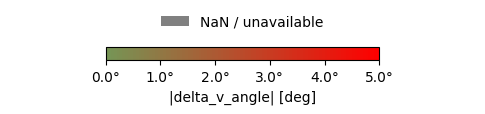

In [12]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch

angle_max_deg = 5.0

cmap = ListedColormap(style_df["hex_color"].tolist())
norm = Normalize(vmin=0.0, vmax=angle_max_deg)

fig, ax = plt.subplots(figsize=(6, 1.2))
fig.subplots_adjust(bottom=0.5)

sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.3, pad=0.25)
cbar.set_label("|delta_v_angle| [deg]")

tick_vals = np.linspace(0, angle_max_deg, 6)
cbar.set_ticks(tick_vals)
cbar.set_ticklabels([f"{v:.1f}°" for v in tick_vals])

ax.axis("off")
ax.legend(handles=[Patch(facecolor="gray", edgecolor="none", label="NaN / unavailable")],
          loc="upper center", bbox_to_anchor=(0.5, 1.6), ncol=1, frameon=False)

plt.show()

network_explorer(network, depth=2, vl_id='STRASP3', nad_profile=diagram_profile, fixed_nad_positions=fixed_positions)